# Explore PICO data

In [1]:
# generic imports
import ast
import collections
import re
import spacy
import scispacy
import time
import numpy as np
from collections import Counter
from itertools import groupby
import itertools
from operator import itemgetter
import csv
import errno
import os
import sqlite3
import string
from collections import defaultdict
from sqlite3 import Error

# DS imports
import pandas as pd
import numpy as np

# visualiation imports 
from matplotlib_dashboard import MatplotlibDashboard
import matplotlib.pyplot as plt
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import seaborn as sns

# NLP imports
import spacy

# Sklearn imports
from sklearn.model_selection import train_test_split

<ipython-input-1-31818598cfd7>:28: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')

random_seed = 0

In [3]:
load_data = '/mnt/nas2/data/systematicReview/semeval2023/data/parsed/st2_train_parsed.tsv'

In [4]:
df = pd.read_csv(load_data, sep='\t')
print(df.shape)

(597, 10)


In [5]:
# Remove empty reddit posts

df_clean = df[~df['claim_offsets'].str.contains('N.A.')]
print(df_clean.shape)

(522, 10)


In [6]:
df_clean.head()

,Unnamed: 0,post_id,subreddit_id,claim,stage2_labels,text,labels_char,claim_offsets,tokens,labels
0,0,sn9u41,t5_2s23e,I read an old thread on here that someone said...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Tysabri experiences\nHi all\n\nI just had my 3...,"[2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, ...","(508, 724)","['Tysabri', 'experiences', 'Hi', 'all', 'I', '...","[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,p7j49y,t5_2syer,"I have read that gout can't be cured, that it'...","[{""crowd-entity-annotation"":{""entities"":[{""end...",Crazy amount of sardines caused gout (possibly...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1401, 1654)","['Crazy', 'amount', 'of', 'sardines', 'caused'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,smgy0q,t5_2s3g1,I always read stories of people who suffer fro...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Im sorry for intruding but I just want to say ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(302, 419)","['Im', 'sorry', 'for', 'intruding', 'but', 'I'...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,sxglhl,t5_2s3g1,Our results indicate that the addition of prob...,"[{""crowd-entity-annotation"":{""entities"":[{""end...",Is Bacillus coagulans supplementation plus low...,"[0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","(1442, 1617)","['Is', 'Bacillus', 'coagulans', 'supplementati...","[0, 2, 2, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 1, ..."
6,6,sfc8e0,t5_2tyg2,"Here it says, in the DSM book","[{""crowd-entity-annotation"":{""entities"":[]}}]",Psychosis (as its described now) doesnt really...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","(1568, 1597)","['Psychosis', '(as', 'its', 'described', 'now)...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [7]:
picos_mapping = {'population': 1, 'intervention':2, 'outcome':3, 'oos':0}

### Reddit post lengths

In [8]:
lengths = [ len( ast.literal_eval(i)) for i in df_clean.tokens ]

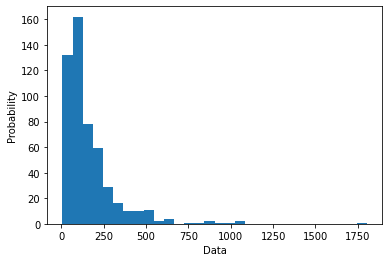

In [9]:
plt.hist(lengths, bins=30)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

### class vs out-of-the-class tokens

In [10]:
def class_ratio(labels, entity):
    
    entity_num = picos_mapping[entity]
    
    out_of_span_counter = 0
    class_counter = 0
    
    for i in labels:
        lab_i = ast.literal_eval(i)
        if len(lab_i)>1:
            counts = collections.Counter( lab_i )
            counts = dict( counts )
            out_of_span_counter = out_of_span_counter + counts[0]
            if entity_num in counts:
                class_counter = class_counter + counts[entity_num]
                
    count_summary = {str(entity): class_counter, 'oos':out_of_span_counter}
                
    return count_summary

{'population': 469, 'oos': 82592}
{'intervention': 882, 'oos': 82592}
{'outcome': 879, 'oos': 82592}


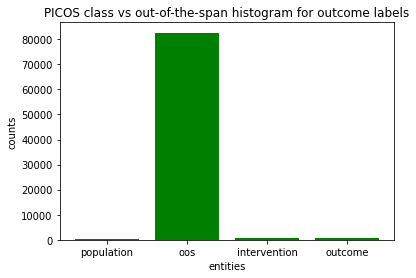

In [11]:
for x in [ 'population', 'intervention', 'outcome' ]:
    count_summary = class_ratio(df_clean.labels, x)
    print( count_summary )
    plt.bar(list(count_summary.keys()), count_summary.values(), color='g')
    plt.title(f'PICOS class vs out-of-the-span histogram for {x} labels')
    plt.xlabel('entities')
    plt.ylabel('counts')

### Inspect the PICO annotations

In [12]:
picos_colors_mapping = {'population': 'green', 'intervention': 'red', 'outcome': 'blue', 'oos':'black'}

In [13]:
def inspect_annots(entity, df_):
    terms_all = []
    terms_lengths = []

    for counter, (tok, lab) in enumerate(zip(df_.tokens.values, df_.labels.values)):
        
        tok = ast.literal_eval(tok)
        lab = ast.literal_eval(lab)
        
        
        captured_ind = []
        captured_cons_ind = []
        for counter_i, (t, l) in  enumerate(zip(tok, lab)):
            if l == picos_mapping[entity]:
                captured_ind.append( counter_i )

        for k, g in groupby(enumerate(captured_ind), lambda ix : ix[0] - ix[1]):
            label_indices = list(map(itemgetter(1), g))
            captured_cons_ind.append( label_indices )

        #print('\n-----------------------------------------------')

        for x in captured_cons_ind:
            #print(x)
            p_term = [tok[x_i] for x_i in x]
            terms_lengths.append( len(p_term) )
            p_term = ' '.join(p_term)
            terms_all.append( p_term )
            
            
    return terms_lengths, terms_all

In [14]:
def plot_common_words(description_list, n):
    # Assign the Counter instance `most_common` call to a variable:
    word_frequency = Counter(" ".join(description_list).split()).most_common(n)

    # `most_common` returns a list of (word, count) tuples
    words = [word for word, _ in word_frequency]
    counts = [counts for _, counts in word_frequency]
    
    fig = plt.figure(figsize=(7, 5))
    plt.bar(words, counts, color = picos_colors_mapping[picos_i])
    plt.title("10 most frequent tokens in the list")
    plt.ylabel("Frequency")
    plt.xlabel("Words")
    plt.xticks(rotation=45, ha='right')

    plt.show()

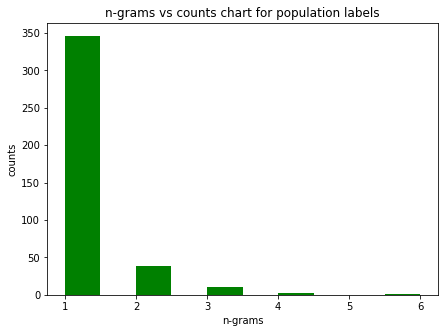

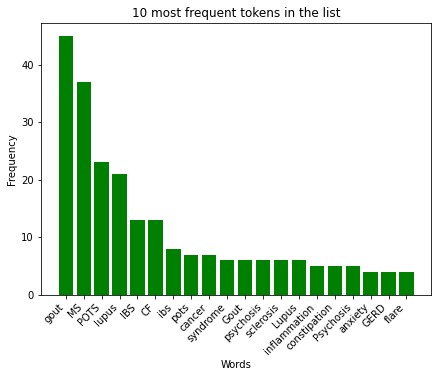

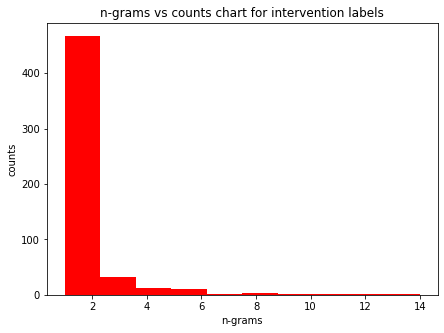

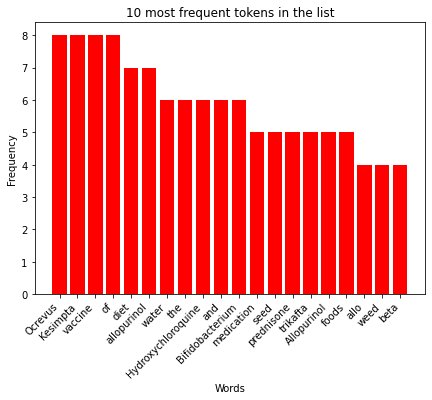

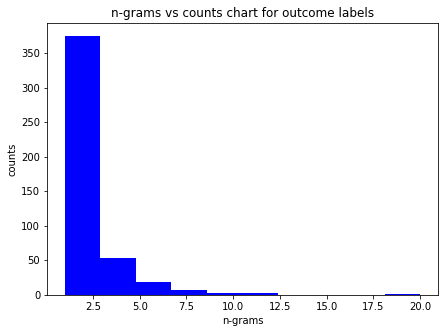

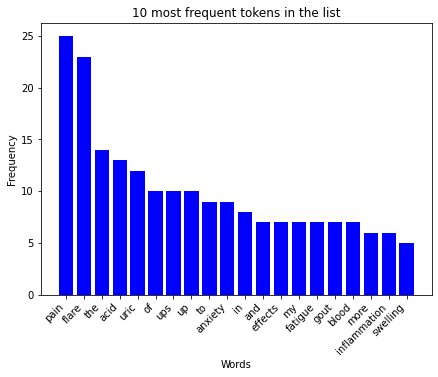

In [15]:
for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)   

    fig = plt.figure(figsize=(7, 5))
    plt.hist( terms_i_lengths, bins=10, color = picos_colors_mapping[picos_i]) 
    plt.title(f'n-grams vs counts chart for {picos_i} labels')
    plt.xlabel('n-grams')
    plt.ylabel('counts')
        
    plt.show()
    
    plot_common_words(terms_i_all, 20)

Some notes: <br>

Participants: Lots of abbreviations. Consider them in the training and could use that in augmentation.

### Class overlap

In [16]:
def class_overlap(tokens, labels):
    
    par = []
    inter = []
    out = []
    oos = []
    
    for t, l in zip(tokens, labels):
        tok_i = ast.literal_eval(t)
        lab_i = ast.literal_eval(l)
        
        if len(lab_i)>1:
            
            for i,j in zip(tok_i, lab_i):
                if j == 0:
                    oos.append(i)
                if j == 1:
                    par.append(i)
                if j == 2:
                    inter.append(i)
                if j == 3:
                    out.append(i)

    return { 'participant': par, 'intervention': inter, 'outcome': out, 'oos': oos }


tokens_dict = class_overlap(df_clean.tokens, df_clean.labels)

In [17]:
for pair in itertools.combinations(['participant','intervention','outcome','oos'], 2):
    
    t1 = tokens_dict[ pair[0] ]
    t2 = tokens_dict[ pair[1] ]
    
    common = list(set(t1).intersection(t2))
    print( f'Common tokens between {pair[0]} and {pair[1]}: {common} \n' )
    print( f'Total number of common tokens between {pair[0]} and {pair[1]}: {len(common)} \n' )
    print(' -------------------------------------------------------------------- ')

Common tokens between participant and intervention: ['vaccines', 'certain', 'SLE', 'patients', 'with', 'cf', 'COVID', 'healthy', 'high', 'blood', 'tachycardia', 'acid', 'Syndrome', 'pots', 'Acid', 'alcohol', 'ANA', 'cancer', 'diet', 'tysabri', 'stress', 'Cystic', 'covid', 'bupropion', 'inflammation', 'pylori', 'Fibrosis'] 

Total number of common tokens between participant and intervention: 27 

 -------------------------------------------------------------------- 
Common tokens between participant and outcome: ['pressure', 'Gout', 'health', 'asthma', 'diarrhea', 'Depression', 'flare', 'rash', 'bowel', 'GERD', 'POTS', 'to', 'seizure', 'high', 'GI', 'blood', 'mental', 'attack', 'Psychosis', 'seizures', 'Sclerosis', 'hernia', 'lupus', 'uric', 'pelvic', 'bad', 'constipation', 'dysfunction', 'constipated', 'Acid', 'sclerosis', 'immune', 'depression', 'gout', 'multiple', 'cancer', 'MS', 'stress', 'Multiple', 'gerd', 'anxiety', 'CF', 'psychosis', 'inflammation', 'esophagus', 'vertigo', 'Lupu

### POS tag distributions

In [18]:
from spacy.glossary import GLOSSARY
lookup_dict = GLOSSARY

In [19]:
lookup_dict

{'ADJ': 'adjective',
 'ADP': 'adposition',
 'ADV': 'adverb',
 'AUX': 'auxiliary',
 'CONJ': 'conjunction',
 'CCONJ': 'coordinating conjunction',
 'DET': 'determiner',
 'INTJ': 'interjection',
 'NOUN': 'noun',
 'NUM': 'numeral',
 'PART': 'particle',
 'PRON': 'pronoun',
 'PROPN': 'proper noun',
 'PUNCT': 'punctuation',
 'SCONJ': 'subordinating conjunction',
 'SYM': 'symbol',
 'VERB': 'verb',
 'X': 'other',
 'EOL': 'end of line',
 'SPACE': 'space',
 '.': 'punctuation mark, sentence closer',
 ',': 'punctuation mark, comma',
 '-LRB-': 'left round bracket',
 '-RRB-': 'right round bracket',
 '``': 'opening quotation mark',
 '""': 'closing quotation mark',
 "''": 'closing quotation mark',
 ':': 'punctuation mark, colon or ellipsis',
 '$': 'symbol, currency',
 '#': 'symbol, number sign',
 'AFX': 'affix',
 'CC': 'conjunction, coordinating',
 'CD': 'cardinal number',
 'DT': 'determiner',
 'EX': 'existential there',
 'FW': 'foreign word',
 'HYPH': 'punctuation mark, hyphen',
 'IN': 'conjunction, su

In [20]:
pos_2_num = dict( zip(lookup_dict.keys(), [*range(len(lookup_dict))]) )

In [21]:
def getPOStags(value):
    
    value = ast.literal_eval(value)
    pos = []
    
    for v in value:
        if type(v) == str:
            doc = en(v)
            tok_pos = [ token.tag_ for token in doc ]
            pos.append( tok_pos[0] )
        else:
            pos.append( 'N.A.' )

    return pos

In [22]:
df_clean['pos'] = df_clean.tokens.progress_apply(getPOStags)

  0%|          | 0/522 [00:00<?, ?it/s]

<ipython-input-22-eecf2b10fe2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['pos'] = df_clean.tokens.progress_apply(getPOStags)


In [23]:
def get_pos_distribution(pos, lab, ent):
    
    pos_ent = []
    
    for p, j in zip( pos, lab ):
            
        #p = ast.literal_eval(i)
        l = ast.literal_eval(j)
    
        for p_i, l_i in zip(p, l):
            if l_i == picos_mapping[ent]:
                pos_ent.append( p_i )
    
    pos_counts = collections.Counter(pos_ent)
    pos_counts = dict( pos_counts.most_common(10) )
    
    fig = plt.figure(figsize=(12, 5))
    plt.bar(pos_counts.keys(), pos_counts.values(), color = picos_colors_mapping[ent])
    plt.title(f'POS tags counts in the {ent} class')
    plt.ylabel("Counts")
    plt.xlabel("POS tags")
    plt.xticks(rotation=45, ha='right')
    plt.show()
    
    # Distribution
    # create figure and axes
    pos_ent_num = [pos_2_num[i] for i in pos_ent]
    graph = sns.displot( data=pos_ent_num, stat='count', height=4, aspect=1.5, kde=True )
    
    return pos_counts

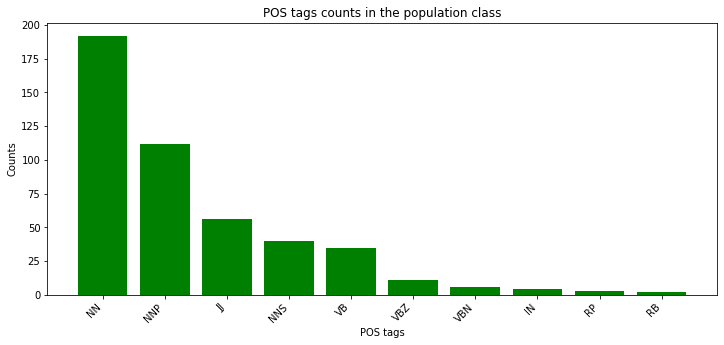

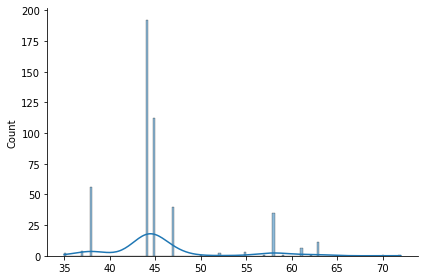

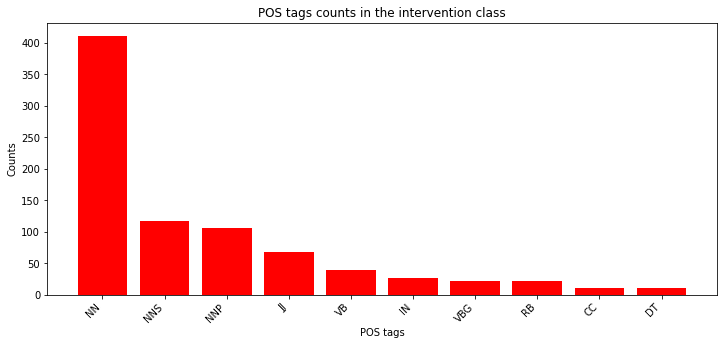

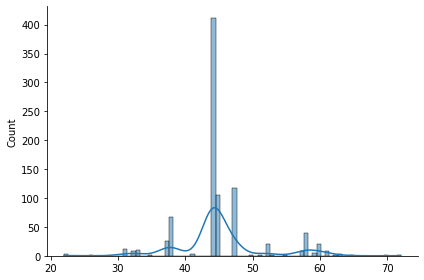

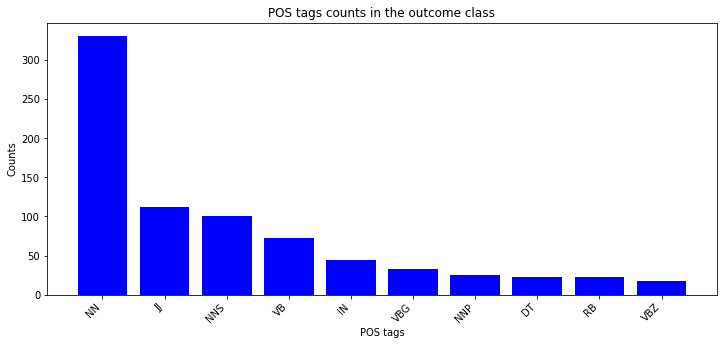

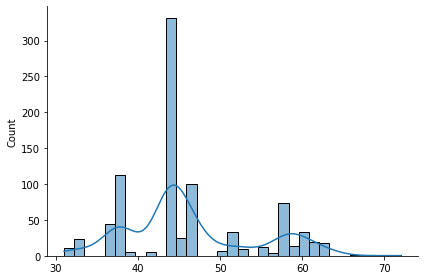

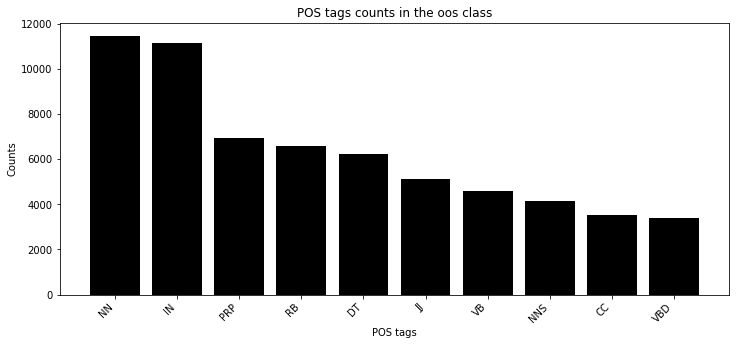

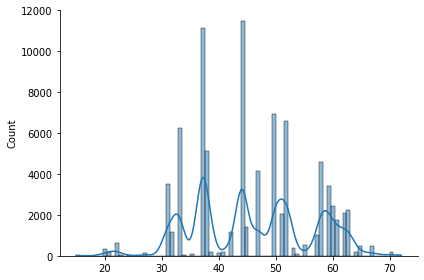

In [24]:
for i in ['population', 'intervention', 'outcome','oos']:
    get_pos_distribution( df_clean.pos, df_clean.labels , i )

Notes: POS tag distributions are different/discriminatory for the PICO tags

### Examine individual PICO

In [26]:
for picos_i in [ 'outcome' ]:
    
    _, terms_i_all = inspect_annots(picos_i, df_clean)
    
    for i in list(set(terms_i_all)):
        print(i)

Gout in shoulders
loose stools
swollen
reduce UA by straight up taking it out of my blood
uric acid production
helped quite a bit to manage my UA levels
body aches
Remission
CBAVD
prevent seizures/auras
heartburn
cavity
Confusion
have not suffer psychosis
pinpoint sized spots of redness
inflammation-induced Gout
colonic inertia
red
Lifechanging
flair ups have been much less frequent
cancer
TMJ
tends to work
inflammation
stabbed
flare ups
bleeds
heartrate
Heart palpitations
discomfort
cardiac arrest
curcumin
shaky jittery
uric acid
blood loss
stomach problems
bloats
lung function
Uric Acid
my heart is okay
cholesterol
achieve targeted uric acid serum levels
Stiff toe
Anxiety
doubled
gout attack
screen for CF
kidneys
burning
heart warning
no side effects
POTS
wheezing
gassy
palpitations
UAs
flare-ups
flare up
flares
mouth sores
chronic pain
Blue foot
neurological and circulatory systems
abdominal cramps
twitching
I havnt had an attack
constipated
dont have any more flare up
spasticity
pe

### Examine social media posts

In [27]:
df_clean.shape

(522, 11)

In [28]:
for i in df_clean.tokens:
    print(i)
    print('-------------------------------')

['Tysabri', 'experiences', 'Hi', 'all', 'I', 'just', 'had', 'my', '3rd', 'tysabri', 'infusion', 'today.', 'I', 'was', 'wondering', 'if', 'any', 'other', 'people', 'on', 'tysabri', 'notice', 'they', 'get', 'a', 'slight', 'worsening', 'of', 'old', 'symptoms', 'hours', 'after', 'infusion?', 'For', 'example,', 'normally', 'my', 'hug', 'only', 'is', 'around', 'the', 'front', 'of', 'my', 'chest,', 'but', 'its', 'wrapped', 'around', 'my', 'back', 'now', 'like', 'it', 'had', 'in', 'the', 'past.', 'Or', 'maybe', 'thats', 'just', 'what', 'back', 'pain', 'feels', 'like', 'So', 'perhaps', 'Im', 'just', 'getting', 'typical', 'side', 'effects.', 'I', 'never', 'have', 'any', 'side', 'effects', 'when', 'Im', 'monitored', 'in', 'the', 'hour', 'after', 'my', 'actual', 'IV', 'drip,', 'though.', 'I', 'read', 'an', 'old', 'thread', 'on', 'here', 'that', 'someone', 'said', 'she', 'thinks', 'that', 'her', 'immune', 'system', 'is', 'retaliating', 'because', 'it', 'can', 'no', 'longer', 'cross', 'the', 'blood'

### Divide the df into training and validation set

In [29]:
train_df, val_df = train_test_split(df_clean, shuffle=False, random_state=random_seed)

In [30]:
# Use validation set directory to build models
participant_labels = []
intervention_labels = []
outcome_labels = []

for picos_i in [ 'population', 'intervention', 'outcome' ]:
    
    terms_i_lengths, terms_i_all = inspect_annots(picos_i, df_clean)
    for t in terms_i_all:
        if picos_i == 'population':
            participant_labels.append(t)
        if picos_i == 'intervention':
            intervention_labels.append(t)
        if picos_i == 'outcome':
            outcome_labels.append(t)

### UMLS inspection

In [31]:
'''
Description:
    Creates a database connection to the SQLite database specified by the db_file

Args:
    db_file (str): Path to the SQLite database 

Returns:
    conn (str): Connection object or None
'''
def createMySQLConn(db_file):

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print('This is the connection: ', conn)
    except Error as e:
        print(e)

    return conn

In [40]:
'''
Description:
    This function selects all rows from UMLS.db for the chosen pico_category.

Args:
    conn (Connection) : MySQL connection to the preprocessed UMLS.db 
    pico_category (str): choice for the entitiy type to retrieve appropriate UMLS concepts from UMLS.db

Returns:
    rows (list): Selected terms (and their SAB label) for  pico_category
'''
def selectTerminology(conn):
    """
    Query all rows in the tasks table
    :param conn: the Connection object
    :return:
    """

    cur = conn.cursor()
    
    cur.execute("SELECT TERM_PRE, STY FROM terminology1")
    results = cur.fetchall()
    
    return results

In [41]:
umls = dict()
indir = '/mnt/nas2/data/systematicReview'
fpath = 'UMLS/english_subset/umls_preprocessed/umls_tui_pios4_.db'
umls_fpath = f'{indir}/{fpath}'
conn = createMySQLConn( umls_fpath )

This is the connection:  <sqlite3.Connection object at 0x7f9b3f8535d0>


In [42]:
results = selectTerminology(conn)

In [43]:
def map_to_sty(p):
    
    term2sty=dict()
    
    for p_i in p:
        if p_i[1] not in term2sty:
            term2sty[ p_i[1] ] = [ p_i[0].lower() ]
        else:
            term2sty[ p_i[1] ].append( p_i[0].lower() )
            
    return term2sty

term_lookup = map_to_sty(results)

In [44]:
def get_ent_sty_lookup(d_labels):
    
    d_2_sty = dict()
    
    for x in d_labels:
        for k, v in term_lookup.items():
            if x.lower() in v:
                if x not in d_2_sty or x.lower():
                    d_2_sty[x.lower()] = [k]
                else:
                    d_2_sty[x.lower()].append(k)
    
    return d_2_sty

In [45]:
participant_labels = list(set(participant_labels))
intervention_labels = list(set(intervention_labels))
outcome_labels = list(set(outcome_labels))

umls_coverage = dict()

for d_labels, picos_i in zip( [ participant_labels, intervention_labels, outcome_labels ], ['population', 'intervention', 'outcome'] ):
    
    pico_2_sty = get_ent_sty_lookup(d_labels)
    umls_coverage[picos_i] = pico_2_sty
    
    print(' ----------------------------------------------------------------  ')
    print( f'\n{picos_i} class terms without any semantic group: \n' )
    for x in d_labels:
        if x.lower() not in pico_2_sty:
            print( x )

 ----------------------------------------------------------------  

population class terms without any semantic group: 

IBS patients
Hashimotos
pelvic spasms
healthy individuals
Visceral Hypersensitivity
common gastrointestinal diagnoses
irritable bowel syndrome management
Kaftrio
COVID-19
immune compromised
SPMS
allergic to vaccines
DID
CFRD
hashimotos
Covid-19
partial bowel dysmotility
flare up
UCTD/lupus
Intestinal Fungal Dysbiosis
SIB0
CFers
generalized epilepsy patients
LPR/GERD
IBS-C
gout/Uric Acid
pylori
CFLD
gastrointestinal motility disorders
DPDR
*POTS
certain diet
MV470v
schizophrenic.
people with pre-existing mental health conditions
R75q
IBS-D
baby with CF
bad flare
asymptomatic newborns with CF
RRMS
Busitus
alcohol neuropathy
Plantar Fasciittis
 ----------------------------------------------------------------  

intervention class terms without any semantic group: 

coagulans
flutter-valve treatment
FODMAP
plant-based diets
80 ounces of water a day
Epstein Barr Virus (E

In [46]:
for k, v in umls_coverage.items():
    
    if k == 'participant':
        coverage = ( len(v) / len(participant_labels) ) * 100
    if k == 'intervention':
        coverage = ( len(v) / len(intervention_labels) ) * 100
    if k == 'outcome':
        coverage = ( len(v) / len(outcome_labels) ) * 100
    
    print(f'For the {k} class, the UMLS coverage is: {coverage}')

NameError: name 'coverage' is not defined